In [1]:
import sys, io
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import nnls
from fractions import Fraction

pd.set_option('display.max_rows', None)

In [2]:
def sct_with_fraction(sc_tup):
    '''
    Convert a Shortcut Collatz Tuple to a reduced fraction
    '''
    p2, p3, c = sc_tup
    fract = Fraction(2**p2 - c, 3**p3)
    return [p2, p3, c, fract.numerator, fract.denominator]
#

def filter_int(sc_fraction_list):
    for fract in sc_fraction_list:
        if fract[1] == 1:
            yield fract[0]
#

# tup expresses a rational number of the form:
#  (2**p2 - c) / (3**p3)

def matrix_start_generator(sc_tup):
    '''
    Generate 2 tuples for the next generation from a single tuple from the current generation
    '''
    p2, p3, c = sc_tup
    t1 = (p2 + 1, p3, c)
    t2 = (p2 + 1, p3 + 1, c*3 + 2**p2)
    return t1, t2
#


def next_generation(prior_generation):
    '''
    Create the next generation from the prior.  We order the tuples so that they
    match up with the order of the matrix solutions for convenience.
    '''
    head_list = []
    tail_list = []
    for sc_tup in prior_generation:
        t1, t2 = matrix_start_generator(sc_tup)
        head_list.append(t1)
        tail_list.append(t2)
    return head_list + tail_list
#

In [3]:
def gen_generation(n_generations):
    gen_1 = [(0,0,0)]
    gen_1_fract = list(map(sct_with_fraction, gen_1))
    print(gen_1_fract)
    gen = gen_1
    for i in range(n_generations):
        gen = next_generation(gen)
        gen_fract = list(map(sct_with_fraction, gen))
        print(gen_fract)
#

In [4]:
gen_generation(10)

[[0, 0, 0, 1, 1]]
[[1, 0, 0, 2, 1], [1, 1, 1, 1, 3]]
[[2, 0, 0, 4, 1], [2, 1, 1, 1, 1], [2, 1, 2, 2, 3], [2, 2, 5, -1, 9]]
[[3, 0, 0, 8, 1], [3, 1, 1, 7, 3], [3, 1, 2, 2, 1], [3, 2, 5, 1, 3], [3, 1, 4, 4, 3], [3, 2, 7, 1, 9], [3, 2, 10, -2, 9], [3, 3, 19, -11, 27]]
[[4, 0, 0, 16, 1], [4, 1, 1, 5, 1], [4, 1, 2, 14, 3], [4, 2, 5, 11, 9], [4, 1, 4, 4, 1], [4, 2, 7, 1, 1], [4, 2, 10, 2, 3], [4, 3, 19, -1, 9], [4, 1, 8, 8, 3], [4, 2, 11, 5, 9], [4, 2, 14, 2, 9], [4, 3, 23, -7, 27], [4, 2, 20, -4, 9], [4, 3, 29, -13, 27], [4, 3, 38, -22, 27], [4, 4, 65, -49, 81]]
[[5, 0, 0, 32, 1], [5, 1, 1, 31, 3], [5, 1, 2, 10, 1], [5, 2, 5, 3, 1], [5, 1, 4, 28, 3], [5, 2, 7, 25, 9], [5, 2, 10, 22, 9], [5, 3, 19, 13, 27], [5, 1, 8, 8, 1], [5, 2, 11, 7, 3], [5, 2, 14, 2, 1], [5, 3, 23, 1, 3], [5, 2, 20, 4, 3], [5, 3, 29, 1, 9], [5, 3, 38, -2, 9], [5, 4, 65, -11, 27], [5, 1, 16, 16, 3], [5, 2, 19, 13, 9], [5, 2, 22, 10, 9], [5, 3, 31, 1, 27], [5, 2, 28, 4, 9], [5, 3, 37, -5, 27], [5, 3, 46, -14, 27], [5, 4, 

In [5]:
def generations(n_generations):
    gen_0 = [(0,0,0)]
    gen_0_fract = list(map(sct_with_fraction, gen_1))
    l = gen_0_fract[0]
    yield [0] + l + [2**l[0] % 3**l[1]]
    gen = gen_0
    for i in range(n_generations):
        gen_prev = gen
        gen = next_generation(gen)
        gen_fract = list(map(sct_with_fraction, gen))
        for l in gen_fract:
            yield [i+1] + l + [2**l[0] % 3**l[1]]
#

In [54]:
def generations_with_backlink(n_generations):    
    p2, p3, c = 0, 0, 0
    fract = Fraction(2**p2 - c, 3**p3)    
    row_0 = [0, p2, p3, c, fract.numerator, fract.denominator, -1, 0, 0, -1, 2]
    
    yield row_0
    
    rows = [row_0]
    for i in range(n_generations):
        rows_prev = rows
        
        head_list = []
        tail_list = []
        for row in rows_prev:
            p2, p3, c = row[1:4]
            
            p2_, p3_, c_ = p2 + 1, p3, c
            fract = Fraction(2**p2_ - c_, 3**p3_)  
            
            head_list.append([i+1, p2_, p3_, c_, fract.numerator, fract.denominator] + row[1:6])
            
            p2_, p3_, c_ = p2 + 1, p3 + 1, c*3 + 2**p2
            fract = Fraction(2**p2_ - c_, 3**p3_)  
            
            tail_list.append([i+1, p2_, p3_, c_, fract.numerator, fract.denominator] + row[1:6])
            
        rows = head_list + tail_list
        for row in rows:
            yield row
#

In [56]:
df_b = pd.DataFrame(list(generations_with_backlink(6)), columns=["gen", "N", "M", "c", "numer", "denom", "prev_N", "prev_M", "prev_c", "p_numer", "p_denom"])
df_b

,gen,N,M,c,numer,denom,prev_N,prev_M,prev_c,p_numer,p_denom
0,0,0,0,0,1,1,-1,0,0,-1,2
1,1,1,0,0,2,1,0,0,0,1,1
2,1,1,1,1,1,3,0,0,0,1,1
3,2,2,0,0,4,1,1,0,0,2,1
4,2,2,1,1,1,1,1,1,1,1,3
5,2,2,1,2,2,3,1,0,0,2,1
6,2,2,2,5,-1,9,1,1,1,1,3
7,3,3,0,0,8,1,2,0,0,4,1
8,3,3,1,1,7,3,2,1,1,1,1
9,3,3,1,2,2,1,2,1,2,2,3


In [6]:
print(list(generations(10)))

[[0, 0, 0, 0, 1, 1, 0], [1, 1, 0, 0, 2, 1, 0], [1, 1, 1, 1, 1, 3, 2], [2, 2, 0, 0, 4, 1, 0], [2, 2, 1, 1, 1, 1, 1], [2, 2, 1, 2, 2, 3, 1], [2, 2, 2, 5, -1, 9, 4], [3, 3, 0, 0, 8, 1, 0], [3, 3, 1, 1, 7, 3, 2], [3, 3, 1, 2, 2, 1, 2], [3, 3, 2, 5, 1, 3, 8], [3, 3, 1, 4, 4, 3, 2], [3, 3, 2, 7, 1, 9, 8], [3, 3, 2, 10, -2, 9, 8], [3, 3, 3, 19, -11, 27, 8], [4, 4, 0, 0, 16, 1, 0], [4, 4, 1, 1, 5, 1, 1], [4, 4, 1, 2, 14, 3, 1], [4, 4, 2, 5, 11, 9, 7], [4, 4, 1, 4, 4, 1, 1], [4, 4, 2, 7, 1, 1, 7], [4, 4, 2, 10, 2, 3, 7], [4, 4, 3, 19, -1, 9, 16], [4, 4, 1, 8, 8, 3, 1], [4, 4, 2, 11, 5, 9, 7], [4, 4, 2, 14, 2, 9, 7], [4, 4, 3, 23, -7, 27, 16], [4, 4, 2, 20, -4, 9, 7], [4, 4, 3, 29, -13, 27, 16], [4, 4, 3, 38, -22, 27, 16], [4, 4, 4, 65, -49, 81, 16], [5, 5, 0, 0, 32, 1, 0], [5, 5, 1, 1, 31, 3, 2], [5, 5, 1, 2, 10, 1, 2], [5, 5, 2, 5, 3, 1, 5], [5, 5, 1, 4, 28, 3, 2], [5, 5, 2, 7, 25, 9, 5], [5, 5, 2, 10, 22, 9, 5], [5, 5, 3, 19, 13, 27, 5], [5, 5, 1, 8, 8, 1, 2], [5, 5, 2, 11, 7, 3, 5], [5, 5, 2

In [7]:
df = pd.DataFrame(list(generations(10)), columns=["gen", "N", "M", "c", "numer", "denom", "mod"])

In [8]:
df

,gen,N,M,c,numer,denom,mod
0,0,0,0,0,1,1,0
1,1,1,0,0,2,1,0
2,1,1,1,1,1,3,2
3,2,2,0,0,4,1,0
4,2,2,1,1,1,1,1
5,2,2,1,2,2,3,1
6,2,2,2,5,-1,9,4
7,3,3,0,0,8,1,0
8,3,3,1,1,7,3,2
9,3,3,1,2,2,1,2


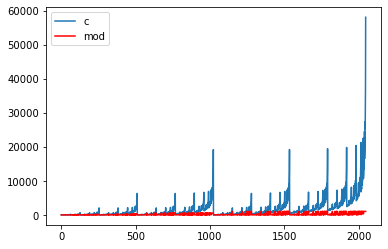

In [9]:
ax = plt.gca()
df.plot(kind='line',y='c',ax=ax)
df.plot(kind='line',y='mod', color='red', ax=ax)
plt.show()

In [10]:
df[(df["numer"]==20) & (df["denom"]==1)]

,gen,N,M,c,numer,denom,mod
67,6,6,1,4,20,1,1
323,8,8,2,76,20,1,4
1347,10,10,3,484,20,1,25


In [11]:
df[(df["gen"]==10) & (df["N"]==10) & (df["denom"]==1)]

,gen,N,M,c,numer,denom,mod
1023,10,10,0,0,1024,1,0
1024,10,10,1,1,341,1,1
1027,10,10,1,4,340,1,1
1028,10,10,2,7,113,1,7
1039,10,10,1,16,336,1,1
1087,10,10,1,64,320,1,1
1089,10,10,2,70,106,1,7
1090,10,10,3,79,35,1,25
1095,10,10,2,88,104,1,7
1097,10,10,3,106,34,1,25


In [12]:
df[(df["numer"]==21) & (df["denom"]==1)]

,gen,N,M,c,numer,denom,mod
64,6,6,1,1,21,1,1
320,8,8,2,67,21,1,4
1344,10,10,3,457,21,1,25


# 20 and 21
Both start in Generation 6 and follow a similar pattern through succeeding generations

# First seen solutions
Every integer, once observed is then present in all future gen+2 generations

Working our way to the right pandas syntax for filtering the data frame down to just the "first seen rows"

First we filter down to the integers:


In [13]:
df[ (df["denom"]==1) ].head()

,gen,N,M,c,numer,denom,mod
0,0,0,0,0,1,1,0
1,1,1,0,0,2,1,0
3,2,2,0,0,4,1,0
4,2,2,1,1,1,1,1
7,3,3,0,0,8,1,0


In [14]:
df[ (df["denom"]==1) ].groupby(["numer"]).idxmin().head()

,gen,N,M,c,denom,mod
numer,,,,,,
1,0,0,0,0,0,0
2,1,1,1,1,1,1
3,34,34,34,34,34,34
4,3,3,3,3,3,3
5,16,16,16,16,16,16


In [15]:
df[ (df["denom"]==1) ].groupby(["numer"]).idxmin()["gen"].head()

numer
1     0
2     1
3    34
4     3
5    16
Name: gen, dtype: int64

In [16]:
df.loc[df[ (df["denom"]==1) ].groupby(["numer"]).idxmin()["gen"]]

,gen,N,M,c,numer,denom,mod
0,0,0,0,0,1,1,0
1,1,1,0,0,2,1,0
34,5,5,2,5,3,1,5
3,2,2,0,0,4,1,0
16,4,4,1,1,5,1,1
69,6,6,2,10,6,1,1
7,3,3,0,0,8,1,0
33,5,5,1,2,10,1,2
1098,10,10,4,133,11,1,52
139,7,7,2,20,12,1,2


In [17]:
df = pd.DataFrame(list(generations(20)), columns=["gen", "N", "M", "c", "numer", "denom", "mod"])

In [18]:
df.loc[df[ (df["denom"]==1) ].groupby(["numer"]).idxmin()["gen"]]

,gen,N,M,c,numer,denom,mod
0,0,0,0,0,1,1,0
1,1,1,0,0,2,1,0
34,5,5,2,5,3,1,5
3,2,2,0,0,4,1,0
16,4,4,1,1,5,1,1
69,6,6,2,10,6,1,1
2198,11,11,5,347,7,1,104
7,3,3,0,0,8,1,0
8796,13,13,6,1631,9,1,173
33,5,5,1,2,10,1,2


In [19]:
df[df["denom"]==1]

,gen,N,M,c,numer,denom,mod
0,0,0,0,0,1,1,0
1,1,1,0,0,2,1,0
3,2,2,0,0,4,1,0
4,2,2,1,1,1,1,1
7,3,3,0,0,8,1,0
9,3,3,1,2,2,1,2
15,4,4,0,0,16,1,0
16,4,4,1,1,5,1,1
19,4,4,1,4,4,1,1
20,4,4,2,7,1,1,7


In [20]:
9 * 2**10

9216

In [21]:
def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    if b < 10:
        return "".join(map(str, digits[::-1]))
    else:
        return digits[::-1]

In [22]:
numberToBase(9, 3)

'100'

In [23]:
numberToBase(28, 3), numberToBase(29, 3), numberToBase(30, 3)

('1001', '1002', '1010')

In [24]:
def collatzNext(n):
    if n == 1:
        return 1
    elif n %2 == 0:
        return n//2
    return (3*n + 1)//2

def collatzSeq(i):
    L = []
    L.append(i)
    while i != 1:
        i = collatzNext(i)
        L.append(i)
    return L



# Finding the Matrix Generator Tuple for a given integer J is easy

##  -- the "lattice" from (0,0,0) is the reversed operation set of the collatz sequence from 1 to J 

For instance the number 5:

It's Collatz sequence is:
  - 5,8,4,2,1
  - Which when generating forward we were rendering:  □□□■  (even, even, even, odd)

It's matrix is:

$$
\begin{bmatrix} 
    -3 & 2 & 0 & 0 & 0 & 0 & 0\\
    0 & -1 & 2 & 0 & 0 & 0 & 0\\
    0 & 0 & -1 & 2 & 0 & 0 & 0\\
    0 & 0 & 0 & -1 & 2 & 0 & 0\\
    0 & 0 & 0 & 0 & \textbf{-3} & \textbf{2} & \textbf{0}\\ 
    0 & 0 & 0 & 0 & \textbf{0} & \textbf{-1} & \textbf{2}\\
    0 & 0 & 0 & 0 & \textbf{-1} & \textbf{0} & \textbf{1} 
\end{bmatrix}
X
=
\begin{bmatrix} 
    1 \\
    0 \\
    0 \\
    0 \\
    \textbf{1} \\ 
    \textbf{0} \\ 
    \textbf{0} 
\end{bmatrix}
$$

$$\implies$$

$$
X
=
\begin{bmatrix} 
    5 \\
    8 \\
    4 \\
    2 \\
    \textbf{1} \\ 
    \textbf{2} \\ 
    \textbf{1}
\end{bmatrix}
$$

It's tuple sequence is:

  - $ (4,1,1) = 5 $
  - $ (3,1,1) = \frac{7}{3} $
  - $ (2,1,1) = 1 $
  - $ (1,1,1) = \frac{1}{3} $
  - $ (0,0,0) = 1 $
  
Which looks like: ■□□□  (down, up, up, up) when moving left to right through tuple lattice starting at (0,0,0)



In [25]:
# Find the collatz triplet tuple for the given number
#

def collatzTup(i):
    steps = []
    
    j = i
    while j != 1:
        if j % 2 == 0:
            steps.append(0)
            j = j//2
        else:
            steps.append(1)
            j = (3*j + 1)//2
    
    sc_tup = (0,0,0)
    for step in steps:
        p2, p3, c = sc_tup
        fract = Fraction(2**p2 - c, 3**p3)
        print(sc_tup, fract.numerator, "/", fract.denominator)
        if step == 0:
            sc_tup = (p2 + 1, p3, c)
        else:
            sc_tup = (p2 + 1, p3 + 1, c*3 + 2**p2)
            
    p2, p3, c = sc_tup
    fract = Fraction(2**p2 - c, 3**p3)
    print(sc_tup, fract.numerator, "/", fract.denominator)
    return sc_tup


In [26]:
collatzTup(5)

(0, 0, 0) 1 / 1
(1, 1, 1) 1 / 3
(2, 1, 1) 1 / 1
(3, 1, 1) 7 / 3
(4, 1, 1) 5 / 1


(4, 1, 1)

In [27]:
sct_with_fraction((6,2,19))

[6, 2, 19, 5, 1]

In [28]:
collatzTup(27)

(0, 0, 0) 1 / 1
(1, 1, 1) 1 / 3
(2, 2, 5) -1 / 9
(3, 2, 5) 1 / 3
(4, 3, 23) -7 / 27
(5, 4, 85) -53 / 81
(6, 5, 287) -223 / 243
(7, 6, 925) -797 / 729
(8, 7, 2903) -2647 / 2187
(9, 7, 2903) -797 / 729
(10, 8, 9221) -8197 / 6561
(11, 8, 9221) -797 / 729
(12, 9, 29711) -25615 / 19683
(13, 10, 93229) -85037 / 59049
(14, 10, 93229) -25615 / 19683
(15, 11, 296071) -263303 / 177147
(16, 12, 920981) -855445 / 531441
(17, 13, 2828479) -2697407 / 1594323
(18, 13, 2828479) -855445 / 531441
(19, 14, 8747581) -8223293 / 4782969
(20, 15, 26767031) -25718455 / 14348907
(21, 16, 81349669) -79252517 / 43046721
(22, 17, 246146159) -241951855 / 129140163
(23, 17, 246146159) -79252517 / 43046721
(24, 18, 746827085) -730049869 / 387420489
(25, 18, 746827085) -79252517 / 43046721
(26, 18, 746827085) -679718221 / 387420489
(27, 19, 2307590119) -2173372391 / 1162261467
(28, 20, 7056988085) -6788552629 / 3486784401
(29, 21, 21439399711) -20902528799 / 10460353203
(30, 21, 21439399711) -6788552629 / 3486784401


(70, 41, 195820718533800070543)

In [45]:
len(numberToBase(195820718533800070543, 2))

68

In [41]:
collatzTup(54)

(0, 0, 0) 1 / 1
(1, 0, 0) 2 / 1
(2, 1, 2) 2 / 3
(3, 2, 10) -2 / 9
(4, 2, 10) 2 / 3
(5, 3, 46) -14 / 27
(6, 4, 170) -106 / 81
(7, 5, 574) -446 / 243
(8, 6, 1850) -1594 / 729
(9, 7, 5806) -5294 / 2187
(10, 7, 5806) -1594 / 729
(11, 8, 18442) -16394 / 6561
(12, 8, 18442) -1594 / 729
(13, 9, 59422) -51230 / 19683
(14, 10, 186458) -170074 / 59049
(15, 10, 186458) -51230 / 19683
(16, 11, 592142) -526606 / 177147
(17, 12, 1841962) -1710890 / 531441
(18, 13, 5656958) -5394814 / 1594323
(19, 13, 5656958) -1710890 / 531441
(20, 14, 17495162) -16446586 / 4782969
(21, 15, 53534062) -51436910 / 14348907
(22, 16, 162699338) -158505034 / 43046721
(23, 17, 492292318) -483903710 / 129140163
(24, 17, 492292318) -158505034 / 43046721
(25, 18, 1493654170) -1460099738 / 387420489
(26, 18, 1493654170) -158505034 / 43046721
(27, 18, 1493654170) -1359436442 / 387420489
(28, 19, 4615180238) -4346744782 / 1162261467
(29, 20, 14113976170) -13577105258 / 3486784401
(30, 21, 42878799422) -41805057598 / 10460353203

(71, 41, 391641437067600141086)

In [46]:
len(numberToBase(391641437067600141086, 2))

69

In [29]:
collatzTup(3)

(0, 0, 0) 1 / 1
(1, 1, 1) 1 / 3
(2, 2, 5) -1 / 9
(3, 2, 5) 1 / 3
(4, 2, 5) 11 / 9
(5, 2, 5) 3 / 1


(5, 2, 5)

In [30]:
collatzTup(3*5)

(0, 0, 0) 1 / 1
(1, 1, 1) 1 / 3
(2, 2, 5) -1 / 9
(3, 3, 19) -11 / 27
(4, 4, 65) -49 / 81
(5, 4, 65) -11 / 27
(6, 4, 65) -1 / 81
(7, 4, 65) 7 / 9
(8, 4, 65) 191 / 81
(9, 5, 451) 61 / 243
(10, 5, 451) 191 / 81
(11, 5, 451) 1597 / 243
(12, 5, 451) 15 / 1


(12, 5, 451)

In [31]:
collatzTup(27*5)

(0, 0, 0) 1 / 1
(1, 1, 1) 1 / 3
(2, 2, 5) -1 / 9
(3, 3, 19) -11 / 27
(4, 3, 19) -1 / 9
(5, 4, 73) -41 / 81
(6, 4, 73) -1 / 9
(7, 4, 73) 55 / 81
(8, 4, 73) 61 / 27
(9, 5, 475) 37 / 243
(10, 6, 1937) -913 / 729
(11, 6, 1937) 37 / 243
(12, 7, 7859) -3763 / 2187
(13, 7, 7859) 37 / 243
(14, 8, 31769) -15385 / 6561
(15, 8, 31769) 37 / 243
(16, 8, 31769) 33767 / 6561
(17, 8, 31769) 33101 / 2187
(18, 9, 226379) 35765 / 19683
(19, 10, 941281) -416993 / 59049
(20, 11, 3348131) -2299555 / 177147
(21, 11, 3348131) -416993 / 59049
(22, 12, 12141545) -7947241 / 531441
(23, 12, 12141545) -416993 / 59049
(24, 12, 12141545) 4635671 / 531441
(25, 13, 53201851) -19647419 / 1594323
(26, 13, 53201851) 4635671 / 531441
(27, 13, 53201851) 81015877 / 1594323
(28, 13, 53201851) 135 / 1


(28, 13, 53201851)

In [32]:
collatzTup(81)

(0, 0, 0) 1 / 1
(1, 1, 1) 1 / 3
(2, 1, 1) 1 / 1
(3, 2, 7) 1 / 9
(4, 2, 7) 1 / 1
(5, 2, 7) 25 / 9
(6, 3, 53) 11 / 27
(7, 4, 223) -95 / 81
(8, 5, 797) -541 / 243
(9, 5, 797) -95 / 81
(10, 5, 797) 227 / 243
(11, 5, 797) 139 / 27
(12, 5, 797) 3299 / 243
(13, 6, 6487) 1705 / 729
(14, 6, 6487) 3299 / 243
(15, 6, 6487) 26281 / 729
(16, 6, 6487) 81 / 1


(16, 6, 6487)

In [33]:
def next_gen_tup(sc_tup):
    p2, p3, c = sc_tup
    fract = Fraction(2**p2 - c, 3**p3)
    print(sc_tup, fract.numerator, "/", fract.denominator)
    
    p2_ = p2 + 2
    p3_ = p3 + 1
    c_ = 2**(p2_) - ((3**(p3_)*(2**p2 - c))//3**p3)
    
    fract = Fraction((2**p2_) - c_, 3**p3_)
    r = (p2_, p3_, c_ )
    print(r, fract.numerator, "/", fract.denominator)
    
    return r

def prev_gen_tup(sc_tup):
    p2, p3, c = sc_tup
    fract = Fraction(2**p2 - c, 3**p3)
    print(sc_tup, fract.numerator, "/", fract.denominator)
    
    p2_ = p2 - 2
    p3_ = p3 - 1
    c_ = 2**(p2_) - (((3**p3_)*(2**p2 - c))//3**p3)
    
    fract = Fraction(2**p2_ - c_, 3**p3_)
    r = (p2_, p3_, c_ )
    print(r, fract.numerator, "/", fract.denominator)
    
    return r


In [34]:
next_gen_tup((4,1,1))

(4, 1, 1) 5 / 1
(6, 2, 19) 5 / 1


(6, 2, 19)

In [35]:
next_gen_tup((70, 41, 195820718533800070543))

(70, 41, 195820718533800070543) 27 / 1
(72, 42, 1768053776318811515053) 27 / 1


(72, 42, 1768053776318811515053)

In [47]:
numberToBase(195820718533800070543, 2)

'10101001110110001110111100100000000011111100111001111000110110001111'

In [48]:
numberToBase(1768053776318811515053, 2)

'10111111101100010101100110101100000001011110110101101101010100010101101'

In [49]:
numberToBase(195820718533800070543, 3)

'1210022122111122111122201121110200210100021'

In [50]:
numberToBase(1768053776318811515053, 3)

'121011021121000121000121220102212210011101001'

In [36]:
prev_gen_tup((6, 2, 19))

(6, 2, 19) 5 / 1
(4, 1, 1) 5 / 1


(4, 1, 1)

In [37]:
prev_gen_tup((70, 41, 195820718533800070543))

(70, 41, 195820718533800070543) 27 / 1
(68, 40, -33109062215184251771) 27 / 1


(68, 40, -33109062215184251771)

In [38]:
next_gen_tup(next_gen_tup(next_gen_tup(next_gen_tup((12, 5, 451)))))

(12, 5, 451) 15 / 1
(14, 6, 5449) 15 / 1
(14, 6, 5449) 15 / 1
(16, 7, 32731) 15 / 1
(16, 7, 32731) 15 / 1
(18, 8, 163729) 15 / 1
(18, 8, 163729) 15 / 1
(20, 9, 753331) 15 / 1


(20, 9, 753331)

### Negative Const in Previous Generation calc
means that we cannot go back any further.

# Matrix Generations == Collatz Steps
The number of steps in a the collatz sequence for a number J is also the minimum matrix generation where we will first see the number appear.


In [39]:
seq_27 = collatzSeq(27)
print(len(seq_27), seq_27)

71 [27, 41, 62, 31, 47, 71, 107, 161, 242, 121, 182, 91, 137, 206, 103, 155, 233, 350, 175, 263, 395, 593, 890, 445, 668, 334, 167, 251, 377, 566, 283, 425, 638, 319, 479, 719, 1079, 1619, 2429, 3644, 1822, 911, 1367, 2051, 3077, 4616, 2308, 1154, 577, 866, 433, 650, 325, 488, 244, 122, 61, 92, 46, 23, 35, 53, 80, 40, 20, 10, 5, 8, 4, 2, 1]


In [40]:
seq_31 = collatzSeq(31)
print(len(seq_31), seq_31)

68 [31, 47, 71, 107, 161, 242, 121, 182, 91, 137, 206, 103, 155, 233, 350, 175, 263, 395, 593, 890, 445, 668, 334, 167, 251, 377, 566, 283, 425, 638, 319, 479, 719, 1079, 1619, 2429, 3644, 1822, 911, 1367, 2051, 3077, 4616, 2308, 1154, 577, 866, 433, 650, 325, 488, 244, 122, 61, 92, 46, 23, 35, 53, 80, 40, 20, 10, 5, 8, 4, 2, 1]


# TODO:  For every solution, examine pattern in c for n and n+2
Hoping to find a constraint we can apply to any number to find n_0 for each number